In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.optimizers.schedules import ExponentialDecay


import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder


import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    


seed_everything(42) # Seed 고정

In [41]:
target = 'ECLO'
light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
child_area_df['시설수'] = 1
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
parking_df.reset_index(inplace=True, drop=True)
parking_df = parking_df.fillna(0)

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
cols = list(test.columns)
cols.append(target)
train = train[cols]

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
train = train.drop(columns=['사고일시'])
test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
test = test.drop(columns=['사고일시'])

location_pattern = r'(\S+) (\S+) (\S+)'
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

road_pattern = r'(.+) - (.+)'
train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train = train.drop(columns=['도로형태'])

test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])

train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)
# train = train.dropna()

train = train.fillna(0)
test = test.fillna(0)

# test_x = test.copy()
# train_x = train[test.columns].copy()
# train_y = train['ECLO'].copy()
categorical_features = list(train.dtypes[train.dtypes == "object"].index)
for i in categorical_features:
    le = LabelEncoder()
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])
    
# minmax_scaler = MinMaxScaler()
# data = minmax_scaler.fit_transform(train.drop('ECLO',axis=1))
# data = pd.DataFrame(data,columns=train.drop('ECLO',axis=1).columns)
# data

Epoch 1/30
Batch 0: Invalid loss, terminating training
   1/1981 [..............................] - ETA: 0s - loss: nan - rmsle: nanBatch 1: Invalid loss, terminating training
Batch 2: Invalid loss, terminating training
Batch 3: Invalid loss, terminating training
Batch 4: Invalid loss, terminating training
Batch 5: Invalid loss, terminating training
Batch 6: Invalid loss, terminating training
Batch 7: Invalid loss, terminating training
Batch 8: Invalid loss, terminating training
Batch 9: Invalid loss, terminating training
Batch 10: Invalid loss, terminating training
Batch 11: Invalid loss, terminating training
Batch 12: Invalid loss, terminating training
Batch 13: Invalid loss, terminating training
Batch 14: Invalid loss, terminating training
Batch 15: Invalid loss, terminating training
Batch 16: Invalid loss, terminating training
Batch 17: Invalid loss, terminating training
Batch 18: Invalid loss, terminating training
Batch 19: Invalid loss, terminating training
Batch 20: Invalid loss

 201/1981 [==>...........................] - ETA: 1s - loss: nan - rmsle: nanBatch 201: Invalid loss, terminating training
Batch 202: Invalid loss, terminating training
Batch 203: Invalid loss, terminating training
Batch 204: Invalid loss, terminating training
Batch 205: Invalid loss, terminating training
Batch 206: Invalid loss, terminating training
Batch 207: Invalid loss, terminating training
Batch 208: Invalid loss, terminating training
Batch 209: Invalid loss, terminating training
Batch 210: Invalid loss, terminating training
Batch 211: Invalid loss, terminating training
Batch 212: Invalid loss, terminating training
Batch 213: Invalid loss, terminating training
Batch 214: Invalid loss, terminating training
Batch 215: Invalid loss, terminating training
Batch 216: Invalid loss, terminating training
Batch 217: Invalid loss, terminating training
Batch 218: Invalid loss, terminating training
Batch 219: Invalid loss, terminating training
Batch 220: Invalid loss, terminating training
Bat

 378/1981 [====>.........................] - ETA: 1s - loss: nan - rmsle: nanBatch 378: Invalid loss, terminating training
Batch 379: Invalid loss, terminating training
Batch 380: Invalid loss, terminating training
Batch 381: Invalid loss, terminating training
Batch 382: Invalid loss, terminating training
Batch 383: Invalid loss, terminating training
Batch 384: Invalid loss, terminating training
Batch 385: Invalid loss, terminating training
Batch 386: Invalid loss, terminating training
Batch 387: Invalid loss, terminating training
Batch 388: Invalid loss, terminating training
Batch 389: Invalid loss, terminating training
Batch 390: Invalid loss, terminating training
Batch 391: Invalid loss, terminating training
Batch 392: Invalid loss, terminating training
Batch 393: Invalid loss, terminating training
Batch 394: Invalid loss, terminating training
Batch 395: Invalid loss, terminating training
Batch 396: Invalid loss, terminating training
Batch 397: Invalid loss, terminating training
Bat

Batch 561: Invalid loss, terminating training
 562/1981 [=======>......................] - ETA: 0s - loss: nan - rmsle: nanBatch 562: Invalid loss, terminating training
Batch 563: Invalid loss, terminating training
Batch 564: Invalid loss, terminating training
Batch 565: Invalid loss, terminating training
Batch 566: Invalid loss, terminating training
Batch 567: Invalid loss, terminating training
Batch 568: Invalid loss, terminating training
Batch 569: Invalid loss, terminating training
Batch 570: Invalid loss, terminating training
Batch 571: Invalid loss, terminating training
Batch 572: Invalid loss, terminating training
Batch 573: Invalid loss, terminating training
Batch 574: Invalid loss, terminating training
Batch 575: Invalid loss, terminating training
Batch 576: Invalid loss, terminating training
Batch 577: Invalid loss, terminating training
Batch 578: Invalid loss, terminating training
Batch 579: Invalid loss, terminating training
Batch 580: Invalid loss, terminating training
Bat

 765/1981 [==========>...................] - ETA: 0s - loss: nan - rmsle: nanBatch 765: Invalid loss, terminating training
Batch 766: Invalid loss, terminating training
Batch 767: Invalid loss, terminating training
Batch 768: Invalid loss, terminating training
Batch 769: Invalid loss, terminating training
Batch 770: Invalid loss, terminating training
Batch 771: Invalid loss, terminating training
Batch 772: Invalid loss, terminating training
Batch 773: Invalid loss, terminating training
Batch 774: Invalid loss, terminating training
Batch 775: Invalid loss, terminating training
Batch 776: Invalid loss, terminating training
Batch 777: Invalid loss, terminating training
Batch 778: Invalid loss, terminating training
Batch 779: Invalid loss, terminating training
Batch 780: Invalid loss, terminating training
Batch 781: Invalid loss, terminating training
Batch 782: Invalid loss, terminating training
Batch 783: Invalid loss, terminating training
Batch 784: Invalid loss, terminating training
Bat

 952/1981 [=============>................] - ETA: 0s - loss: nan - rmsle: nanBatch 952: Invalid loss, terminating training
Batch 953: Invalid loss, terminating training
Batch 954: Invalid loss, terminating training
Batch 955: Invalid loss, terminating training
Batch 956: Invalid loss, terminating training
Batch 957: Invalid loss, terminating training
Batch 958: Invalid loss, terminating training
Batch 959: Invalid loss, terminating training
Batch 960: Invalid loss, terminating training
Batch 961: Invalid loss, terminating training
Batch 962: Invalid loss, terminating training
Batch 963: Invalid loss, terminating training
Batch 964: Invalid loss, terminating training
Batch 965: Invalid loss, terminating training
Batch 966: Invalid loss, terminating training
Batch 967: Invalid loss, terminating training
Batch 968: Invalid loss, terminating training
Batch 969: Invalid loss, terminating training
Batch 970: Invalid loss, terminating training
Batch 971: Invalid loss, terminating training
Bat

1171/1981 [================>.............] - ETA: 0s - loss: nan - rmsle: nanBatch 1171: Invalid loss, terminating training
Batch 1172: Invalid loss, terminating training
Batch 1173: Invalid loss, terminating training
Batch 1174: Invalid loss, terminating training
Batch 1175: Invalid loss, terminating training
Batch 1176: Invalid loss, terminating training
Batch 1177: Invalid loss, terminating training
Batch 1178: Invalid loss, terminating training
Batch 1179: Invalid loss, terminating training
Batch 1180: Invalid loss, terminating training
Batch 1181: Invalid loss, terminating training
Batch 1182: Invalid loss, terminating training
Batch 1183: Invalid loss, terminating training
Batch 1184: Invalid loss, terminating training
Batch 1185: Invalid loss, terminating training
Batch 1186: Invalid loss, terminating training
Batch 1187: Invalid loss, terminating training
Batch 1188: Invalid loss, terminating training
Batch 1189: Invalid loss, terminating training
Batch 1190: Invalid loss, term

Batch 1341: Invalid loss, terminating training
1342/1981 [===================>..........] - ETA: 0s - loss: nan - rmsle: nanBatch 1342: Invalid loss, terminating training
Batch 1343: Invalid loss, terminating training
Batch 1344: Invalid loss, terminating training
Batch 1345: Invalid loss, terminating training
Batch 1346: Invalid loss, terminating training
Batch 1347: Invalid loss, terminating training
Batch 1348: Invalid loss, terminating training
Batch 1349: Invalid loss, terminating training
Batch 1350: Invalid loss, terminating training
Batch 1351: Invalid loss, terminating training
Batch 1352: Invalid loss, terminating training
Batch 1353: Invalid loss, terminating training
Batch 1354: Invalid loss, terminating training
Batch 1355: Invalid loss, terminating training
Batch 1356: Invalid loss, terminating training
Batch 1357: Invalid loss, terminating training
Batch 1358: Invalid loss, terminating training
Batch 1359: Invalid loss, terminating training
Batch 1360: Invalid loss, term

Batch 1528: Invalid loss, terminating training
Batch 1529: Invalid loss, terminating training
Batch 1530: Invalid loss, terminating training
1531/1981 [======================>.......] - ETA: 0s - loss: nan - rmsle: nanBatch 1531: Invalid loss, terminating training
Batch 1532: Invalid loss, terminating training
Batch 1533: Invalid loss, terminating training
Batch 1534: Invalid loss, terminating training
Batch 1535: Invalid loss, terminating training
Batch 1536: Invalid loss, terminating training
Batch 1537: Invalid loss, terminating training
Batch 1538: Invalid loss, terminating training
Batch 1539: Invalid loss, terminating training
Batch 1540: Invalid loss, terminating training
Batch 1541: Invalid loss, terminating training
Batch 1542: Invalid loss, terminating training
Batch 1543: Invalid loss, terminating training
Batch 1544: Invalid loss, terminating training
Batch 1545: Invalid loss, terminating training
Batch 1546: Invalid loss, terminating training
Batch 1547: Invalid loss, term

1724/1981 [=========================>....] - ETA: 0s - loss: nan - rmsle: nanBatch 1724: Invalid loss, terminating training
Batch 1725: Invalid loss, terminating training
Batch 1726: Invalid loss, terminating training
Batch 1727: Invalid loss, terminating training
Batch 1728: Invalid loss, terminating training
Batch 1729: Invalid loss, terminating training
Batch 1730: Invalid loss, terminating training
Batch 1731: Invalid loss, terminating training
Batch 1732: Invalid loss, terminating training
Batch 1733: Invalid loss, terminating training
Batch 1734: Invalid loss, terminating training
Batch 1735: Invalid loss, terminating training
Batch 1736: Invalid loss, terminating training
Batch 1737: Invalid loss, terminating training
Batch 1738: Invalid loss, terminating training
Batch 1739: Invalid loss, terminating training
Batch 1740: Invalid loss, terminating training
Batch 1741: Invalid loss, terminating training
Batch 1742: Invalid loss, terminating training
Batch 1743: Invalid loss, term

1903/1981 [===========================>..] - ETA: 0s - loss: nan - rmsle: nanBatch 1903: Invalid loss, terminating training
Batch 1904: Invalid loss, terminating training
Batch 1905: Invalid loss, terminating training
Batch 1906: Invalid loss, terminating training
Batch 1907: Invalid loss, terminating training
Batch 1908: Invalid loss, terminating training
Batch 1909: Invalid loss, terminating training
Batch 1910: Invalid loss, terminating training
Batch 1911: Invalid loss, terminating training
Batch 1912: Invalid loss, terminating training
Batch 1913: Invalid loss, terminating training
Batch 1914: Invalid loss, terminating training
Batch 1915: Invalid loss, terminating training
Batch 1916: Invalid loss, terminating training
Batch 1917: Invalid loss, terminating training
Batch 1918: Invalid loss, terminating training
Batch 1919: Invalid loss, terminating training
Batch 1920: Invalid loss, terminating training
Batch 1921: Invalid loss, terminating training
Batch 1922: Invalid loss, term

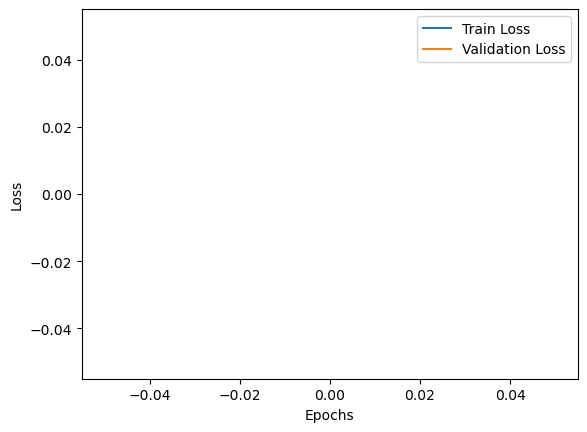

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:60                                                                                   │
│                                                                                                  │
│   57                                                                                             │
│   58 # 모델 평가                                                                                 │
│   59 y_pred = model.predict(X_test)                                                              │
│ ❱ 60 mae = mean_absolute_error(y_test, y_pred)                                                   │
│   61 rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_pred))                               │
│   62 print(f'RMSLE on Test Data: {rmsle_score}')                                                 │
│   63                                                                                             │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_regression.py:196 in     │
│ mean_absolute_error                                                                              │
│                                                                                                  │
│    193 │   >>> mean_absolute_error(y_true, y_pred, multioutput=[0.3, 0.7])                       │
│    194 │   0.85...                                                                               │
│    195 │   """                                                                                   │
│ ❱  196 │   y_type, y_true, y_pred, multioutput = _check_reg_targets(                             │
│    197 │   │   y_true, y_pred, multioutput                                                       │
│    198 │   )                                                                                     │
│    199 │   check_consistent_length(y_true, y_pred, sample_weight)                                │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_regression.py:102 in     │
│ _check_reg_targets                                                                               │
│                                                                                                  │
│     99 │   """                                                                                   │
│    100 │   check_consistent_length(y_true, y_pred)                                               │
│    101 │   y_true = check_array(y_true, ensure_2d=False, dtype=dtype)                            │
│ ❱  102 │   y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)                            │
│    103 │                                                                                         │
│    104 │   if y_true.ndim == 1:                                                                  │
│    105 │   │   y_true = y_true.reshape((-1, 1))                                                  │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\utils\validation.py:921 in        │
│ check_array                                                                                      │
│                                                                                                  │
│    918 │   │   │   )                                                                             │
│    919 │   │                                                                                     │
│    920 │   │   if force_all_finite:                                                              │
│ ❱  921 │   │   │   _assert_all_finite(                         

In [55]:
# 특성과 타겟 데이터 분리
X = train.drop('ECLO',axis=1)
y = train['ECLO']

X = X.astype('float64')
y = y.astype('float64')

# 훈련 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RMSLE 손실 함수 정의
def rmsle(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

# 시퀀셜 모델 구축
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_dim=X_train.shape[1], dtype='float32'),
#     BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu', dtype='float32'),
#     BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear', dtype='float32')
])

# 초기 학습률 설정
initial_learning_rate = 0.001

# 학습률 스케줄링 설정
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,  # 학습률을 얼마나 자주 감소시킬지 결정
    decay_rate=0.1,     # 감소 비율
    staircase=True)

# 옵티마이저에 학습률 스케줄 적용
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# 모델 컴파일
model.compile(optimizer=optimizer, loss=rmsle, metrics=[rmsle])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
terminate_on_nan = TerminateOnNaN()

# tf.keras.backend.clear_session()
# tf.random.set_seed(42)

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test)
                  , callbacks=[early_stopping, terminate_on_nan])

# 훈련 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(f'RMSLE on Test Data: {rmsle_score}')

In [113]:
target = 'ECLO'
light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
child_area_df['시설수'] = 1
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
parking_df.reset_index(inplace=True, drop=True)
parking_df = parking_df.fillna(0)

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
cols = list(test.columns)
cols.append(target)
train = train[cols]

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
train = train.drop(columns=['사고일시'])
test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
test = test.drop(columns=['사고일시'])

location_pattern = r'(\S+) (\S+) (\S+)'
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

road_pattern = r'(.+) - (.+)'
train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train = train.drop(columns=['도로형태'])

test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])

train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)
# train = train.dropna()

train = train.fillna(0)
test = test.fillna(0)

# test_x = test.copy()
# train_x = train[test.columns].copy()
# train_y = train['ECLO'].copy()
categorical_features = list(train.dtypes[train.dtypes == "object"].index)
for i in categorical_features:
    le = LabelEncoder()
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])
    
# minmax_scaler = MinMaxScaler()
# data = minmax_scaler.fit_transform(train.drop('ECLO',axis=1))
# data = pd.DataFrame(data,columns=train.drop('ECLO',axis=1).columns)
# data

In [114]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


def rmsle(y_true, y_pred):
    # 예측값과 실제값에 1을 더하고 로그 씌우기
    log_pred = np.log1p(y_pred)
    log_true = np.log1p(y_true)
    
    # 제곱 오차 계산
    squared_error = (log_pred - log_true) ** 2
    
    # 평균 제곱 오차 계산
    mean_squared_error = np.mean(squared_error)
    
    # 루트 씌우기 (Root Mean Squared Error)
    rmsle_score = np.sqrt(mean_squared_error)
    
    return rmsle_score

X = train.drop(target,axis=1)
y = train[target]

# 훈련 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# MLP 모델 초기화
mlp_model = MLPRegressor(hidden_layer_sizes=(32, 16), 
                         max_iter=1000, 
                         random_state=42, 
                         batch_size=128, 
                         solver='adam',
                         learning_rate='adaptive',
                         learning_rate_init=0.01,
                         early_stopping=True,
                         validation_fraction=0.1,
                         activation='relu',
                         alpha=0.0001,
                         verbose=1)

# 모델 훈련
mlp_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = mlp_model.predict(X_test)

# 평가 지표 출력 (예: 평균 제곱 오차)
mse = rmsle(y_test, y_pred)
print(f'RMSLE: {mse}')


Iteration 1, loss = 261532.36653002
Validation score: -15.070912
Iteration 2, loss = 45.43708394
Validation score: -3.940771
Iteration 3, loss = 25.76355211
Validation score: -8.897161
Iteration 4, loss = 32.15018503
Validation score: -2.737772
Iteration 5, loss = 15.47314428
Validation score: -1.433850
Iteration 6, loss = 12.97435224
Validation score: -1.169729
Iteration 7, loss = 36.27204762
Validation score: -2.493052
Iteration 8, loss = 236.31131224
Validation score: -22.417561
Iteration 9, loss = 1709.15108224
Validation score: -181.405654
Iteration 10, loss = 2137.01569833
Validation score: -8.223862
Iteration 11, loss = 2770.29678328
Validation score: -5030.638529
Iteration 12, loss = 7606.42903329
Validation score: -2.353304
Iteration 13, loss = 14.67760743
Validation score: -0.692514
Iteration 14, loss = 15.68152206
Validation score: -71.515574
Iteration 15, loss = 320.80100778
Validation score: -0.575148
Iteration 16, loss = 13.00834775
Validation score: -0.271622
Iteration 1

In [192]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import numpy as np
tf.random.set_seed(42)

# 예제 데이터 생성 (적절한 데이터로 대체해야 함)
X = train.drop(target,axis=1).astype('float32') 
y = train[target].astype('float32') 

# 훈련 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링 (표준화)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# RMSLE 손실 함수 정의
def rmsle_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

# 모델 구축
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

learning_rate = 0.02  # 적절한 learning rate를 설정해야 함
optimizer = Adam(learning_rate=learning_rate)
# # 초기 학습률 설정
initial_learning_rate = 0.05

# 학습률 스케줄링 설정
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,  # 학습률을 얼마나 자주 감소시킬지 결정
    decay_rate=0.1)     # 감소 비율
#     staircase=True)

# 옵티마이저에 학습률 스케줄 적용
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# 모델 컴파일
model.compile(optimizer=optimizer, loss=rmsle_loss)

# 모델 훈련
model.fit(X_train_scaled, y_train, epochs=30, batch_size=16, verbose=1)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test_scaled).flatten()

def rmsle(y_true, y_pred):
    # 예측값과 실제값에 1을 더하고 로그 씌우기
    log_pred = np.log1p(y_pred)
    log_true = np.log1p(y_true)
    
    # 제곱 오차 계산
    squared_error = (log_pred - log_true) ** 2
    
    # 평균 제곱 오차 계산
    mean_squared_error = np.mean(squared_error)
    
    # 루트 씌우기 (Root Mean Squared Error)
    rmsle_score = np.sqrt(mean_squared_error)
    
    return rmsle_score

# RMSLE 계산
rmsle_score = rmsle(y_test, y_pred)
print(f'RMSLE on Test Data: {rmsle_score}')


Epoch 1/30
1981/1981 [==============================] - 1s 505us/step - loss: 0.4520
Epoch 2/30
1981/1981 [==============================] - 1s 446us/step - loss: 0.4490
Epoch 3/30
1981/1981 [==============================] - 1s 447us/step - loss: 0.4489
Epoch 4/30
1981/1981 [==============================] - 1s 466us/step - loss: 0.4486
Epoch 5/30
1981/1981 [==============================] - 1s 452us/step - loss: 0.4492
Epoch 6/30
1981/1981 [==============================] - 1s 444us/step - loss: 0.4491
Epoch 7/30
1981/1981 [==============================] - 1s 472us/step - loss: 0.4488
Epoch 8/30
1981/1981 [==============================] - 1s 453us/step - loss: 0.4485
Epoch 9/30
1981/1981 [==============================] - 1s 448us/step - loss: 0.4488
Epoch 10/30
1981/1981 [==============================] - 1s 451us/step - loss: 0.4488
Epoch 11/30
1981/1981 [==============================] - 1s 456us/step - loss: 0.4488
Epoch 12/30
1981/1981 [==============================] - 1s 492

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm

tf.random.set_seed(42)

# 예제 데이터 생성 (적절한 데이터로 대체해야 함)
X = train.drop(target,axis=1).astype('float32') 
y = train[target].astype('float32') 

# 훈련 데이터와 테스트 데이터로 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링 (표준화)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
# X_scaled = scaler.transform(X_test) 

# RMSLE 손실 함수 정의
def rmsle_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

def rmsle(y_true, y_pred):
    # 예측값과 실제값에 1을 더하고 로그 씌우기
    log_pred = np.log1p(y_pred)
    log_true = np.log1p(y_true)
    
    # 제곱 오차 계산
    squared_error = (log_pred - log_true) ** 2
    
    # 평균 제곱 오차 계산
    mean_squared_error = np.mean(squared_error)
    
    # 루트 씌우기 (Root Mean Squared Error)
    rmsle_score = np.sqrt(mean_squared_error)
    
    return rmsle_score

# K-fold 교차 검증 설정
n_splits = 10  # 폴드의 개수
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
learning_rate = 0.001
batch_size = 16

# 각 폴드에 대한 결과 저장
result = []

# K-fold 교차 검증 수행
for learning_rate, batch_size in tqdm([[0.001,8],[0.001,16],[0.001,32],
                                       [0.005,8],[0.005,16],[0.005,32],
                                       [0.01,8],[0.01,16],[0.01,32]]):
    rmsle_scores = []
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 모델 구축
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_dim=X_scaled.shape[1]),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='linear')
        ])

        # Adam 옵티마이저 설정
        optimizer = Adam(learning_rate=learning_rate)

        # 모델 컴파일
        model.compile(optimizer=optimizer, loss=rmsle_loss)

        # 모델 훈련
        model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1)

        # 테스트 데이터에 대한 예측
        y_pred = model.predict(X_test).flatten()

        # RMSLE 계산 및 결과 저장
        rmsle_score = rmsle(y_test, y_pred)
        rmsle_scores.append(rmsle_score)

    # 결과 출력
    average_rmsle = np.mean(rmsle_scores)
    result.append(average_rmsle)
    print(f'Average RMSLE across {n_splits} folds: {average_rmsle}')


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

Epoch 1/50
263/263 [==============================] - 0s 671us/step - loss: 0.5996
Epoch 2/50
263/263 [==============================] - 0s 469us/step - loss: 0.4536
Epoch 3/50
263/263 [==============================] - 0s 464us/step - loss: 0.4514
Epoch 4/50
263/263 [==============================] - 0s 417us/step - loss: 0.4477
Epoch 5/50
263/263 [==============================] - 0s 477us/step - loss: 0.4455
Epoch 6/50
263/263 [==============================] - 0s 439us/step - loss: 0.4476
Epoch 7/50
263/263 [==============================] - 0s 428us/step - loss: 0.4427
Epoch 8/50
263/263 [==============================] - 0s 435us/step - loss: 0.4446
Epoch 9/50
263/263 [==============================] - 0s 421us/step - loss: 0.4414
Epoch 10/50
263/263 [==============================] - 0s 435us/step - loss: 0.4415
Epoch 11/50
263/263 [==============================] - 0s 458us/step - loss: 0.4407
Epoch 12/50
263/263 [==============================] - 0s 455us/step - loss: 0.4401
E

263/263 [==============================] - 0s 453us/step - loss: 0.3944
Epoch 49/50
263/263 [==============================] - 0s 441us/step - loss: 0.3976
Epoch 50/50
263/263 [==============================] - 0s 449us/step - loss: 0.3940
Epoch 1/50
263/263 [==============================] - 0s 430us/step - loss: 0.5229
Epoch 2/50
263/263 [==============================] - 0s 430us/step - loss: 0.4544
Epoch 3/50
263/263 [==============================] - 0s 465us/step - loss: 0.4500
Epoch 4/50
263/263 [==============================] - 0s 435us/step - loss: 0.4459
Epoch 5/50
263/263 [==============================] - 0s 469us/step - loss: 0.4415
Epoch 6/50
263/263 [==============================] - 0s 436us/step - loss: 0.4442
Epoch 7/50
263/263 [==============================] - 0s 443us/step - loss: 0.4425
Epoch 8/50
263/263 [==============================] - 0s 435us/step - loss: 0.4388
Epoch 9/50
263/263 [==============================] - 0s 443us/step - loss: 0.4390
Epoch 10/50
2

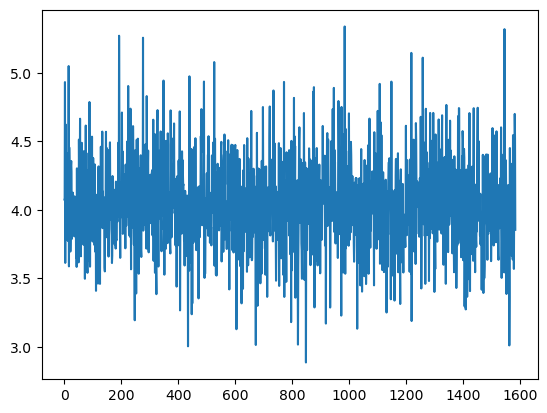

In [210]:
plt.plot(model.predict(X_test))